<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/main/1_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download the data

In [3]:
manager.train_path

'/content/gdrive/MyDrive/ML/Competitions/10.ParisHousePrices/Data/train.csv'

In [4]:
df_source = pd.read_csv(manager.train_path, index_col='id')
df_submission = pd.read_csv(manager.test_path, index_col='id')

In [5]:
df_source.shape, df_submission.shape

((22730, 17), (15154, 16))

# NAN check

In [ ]:
from sklearn_utils import nan_report

_ = nan_report(df_source, 0.0)

0 / 17 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)


In [ ]:
_ = nan_report(df_submission, 0.0)

0 / 16 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)


# INF check

In [ ]:
from sklearn_utils import inf_report

_ = inf_report(df_source, 0.0)
_ = inf_report(df_submission, 0.0)

No infinite values observed
No infinite values observed


# Check outliers before splitting the data

## Visualize outliers

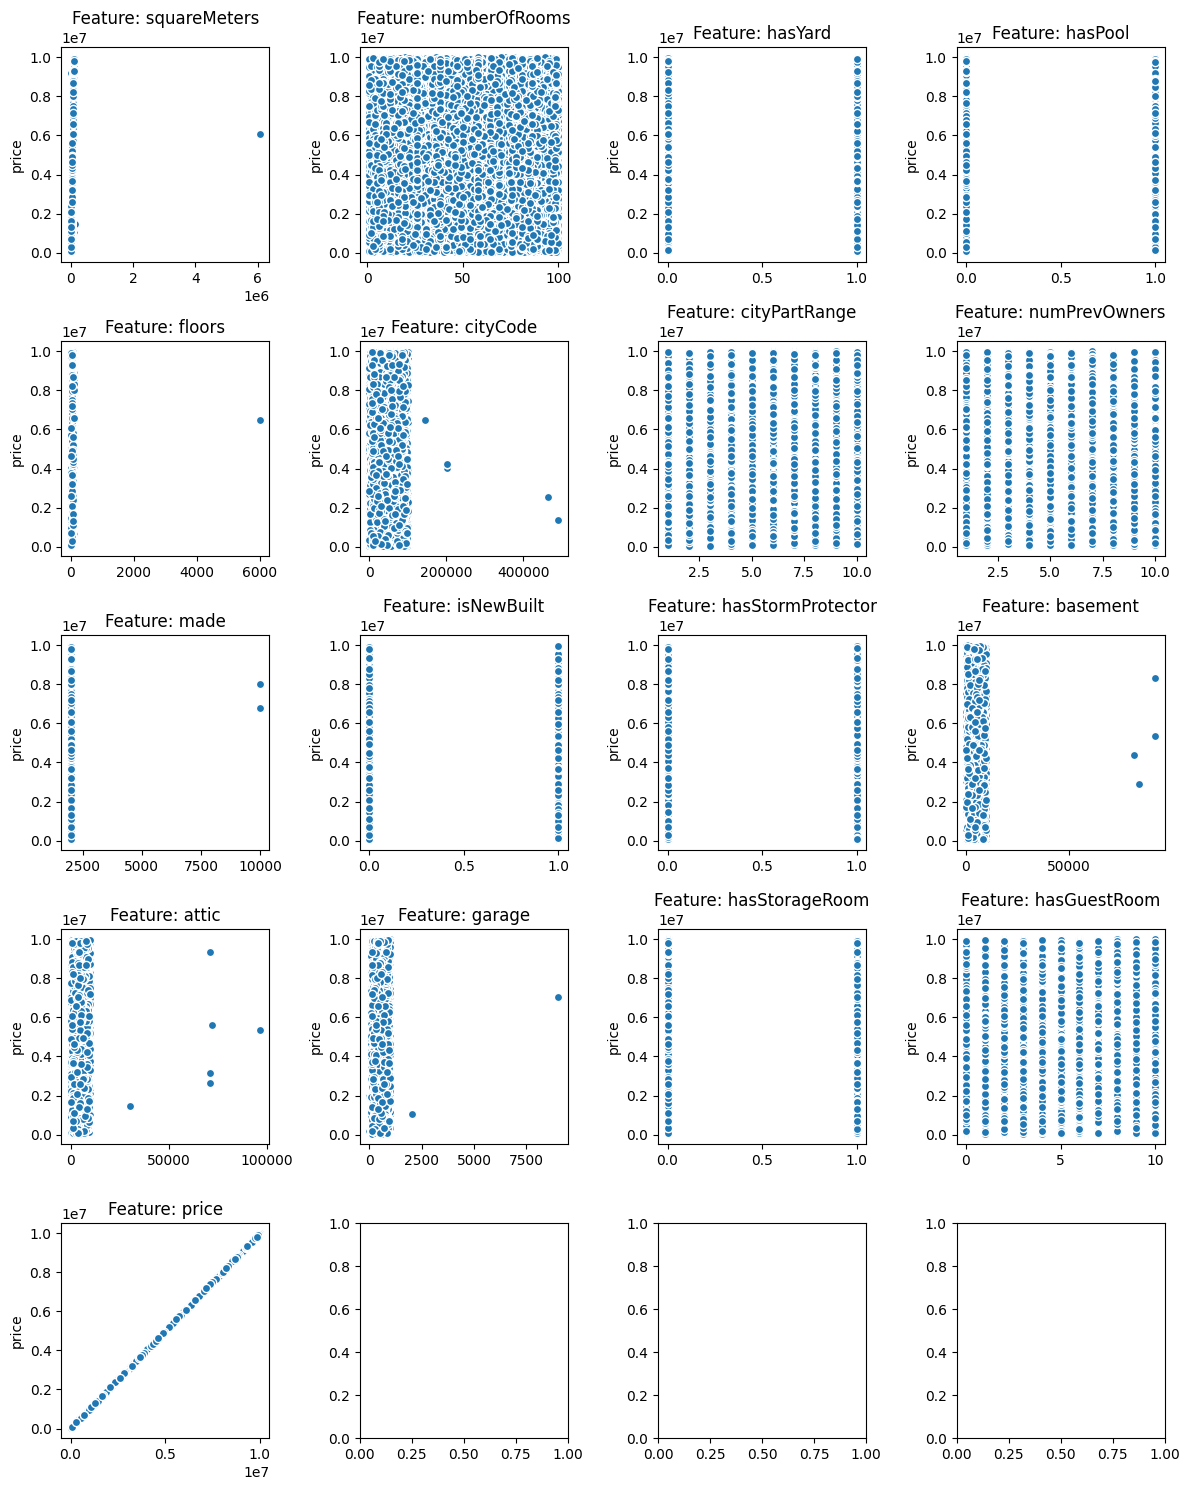

In [6]:
from sklearn_utils import visualize_target_vs_columns

visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

## IQR cleaning

In [7]:
def plot_quantile_outliers(df, column_quantile_dict, n_cols=5):
    temp = len(column_quantile_dict.keys()) // n_cols
    n_rows = temp if len(column_quantile_dict.keys()) % n_cols == 0 else temp + 1

    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
    ax = ax.flatten()
    counter = 0
    outlier_indices = list()
    for column_name, quantile in column_quantile_dict.items():

        subset = df.loc[
            df[column_name] > df_source[column_name].quantile(quantile)
        ]
        print(f'For {column_name}: {subset.shape[0]} outliers')
        print(f'Indices: {list(subset.index)}')

        outlier_indices += list(subset.index)

        ax[counter].scatter(df_source[column_name], df_source['price'])
        ax[counter].scatter(subset[column_name], subset['price'])
        ax[counter].set_ylabel('price')
        ax[counter].set_xlabel(column_name)

        counter += 1
    return set(outlier_indices)

For squareMeters: 20 outliers
Indices: [648, 2323, 3184, 3515, 4657, 4741, 5261, 8054, 8533, 10043, 13686, 14864, 15334, 15749, 17330, 17742, 19081, 19438, 19978, 21320]
For floors: 1 outliers
Indices: [5659]
For cityCode: 7 outliers
Indices: [299, 1326, 2425, 10987, 20576, 20735, 22631]
For made: 5 outliers
Indices: [2113, 3608, 19124, 19748, 21400]
For basement: 4 outliers
Indices: [2107, 3995, 15068, 18926]
For attic: 7 outliers
Indices: [3828, 4909, 12858, 13633, 13642, 17168, 19994]
For garage: 2 outliers
Indices: [14878, 17629]


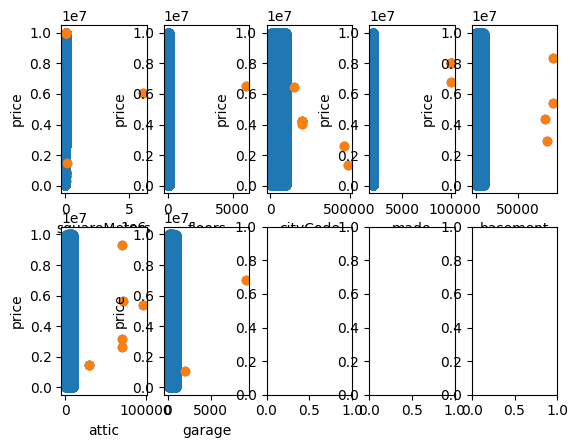

In [8]:
outlier_indices = plot_quantile_outliers(
    df_source,
    {
        'squareMeters': 0.999,
        'floors': 0.999,
        'cityCode': 0.9997,
        'made': 0.999,
        'basement': 0.9995,
        'attic': 0.9995,
        'garage': 0.999
    }
)

In [9]:
len(outlier_indices) / df_source.shape[0]

0.002023757149142103

In [10]:
print(f'Data size before IQR cleaning: {df_source.shape}')
df_source = df_source.iloc[~df_source.index.isin(outlier_indices), :]
print(f'Data size after IQR cleaning: {df_source.shape}')

Data size before IQR cleaning: (22730, 17)
Data size after IQR cleaning: (22684, 17)


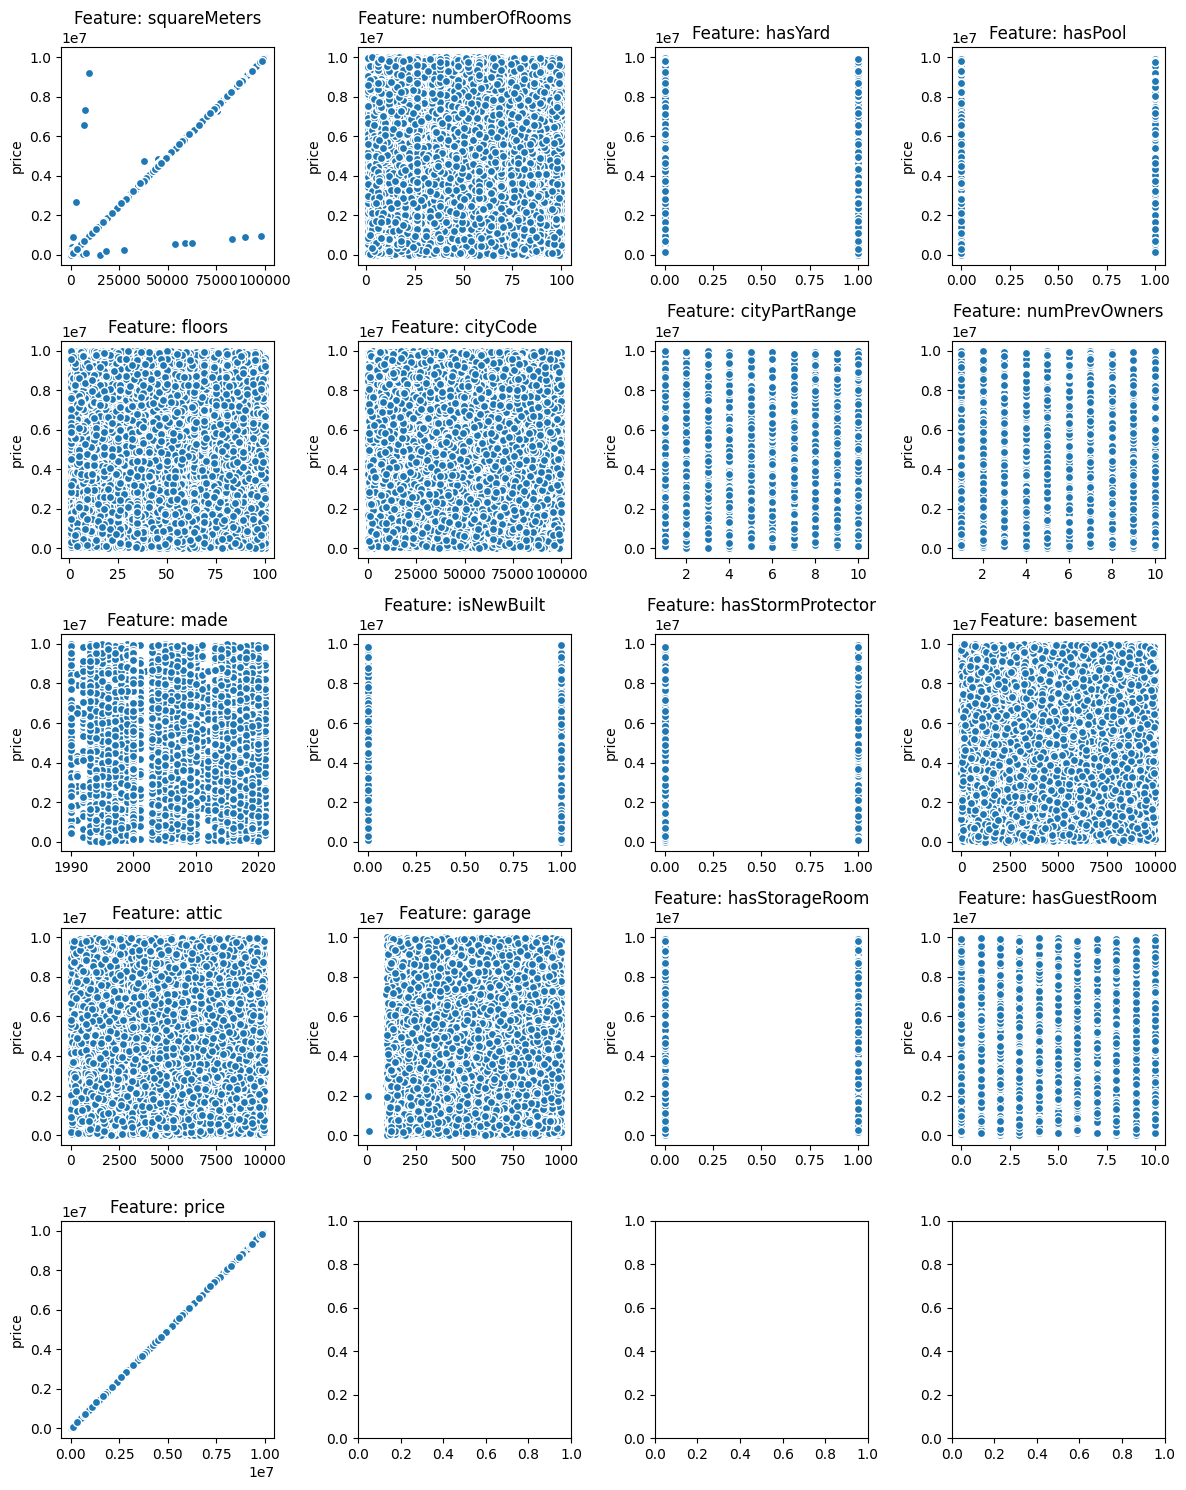

In [11]:
visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

## Local outlier factor cleaning

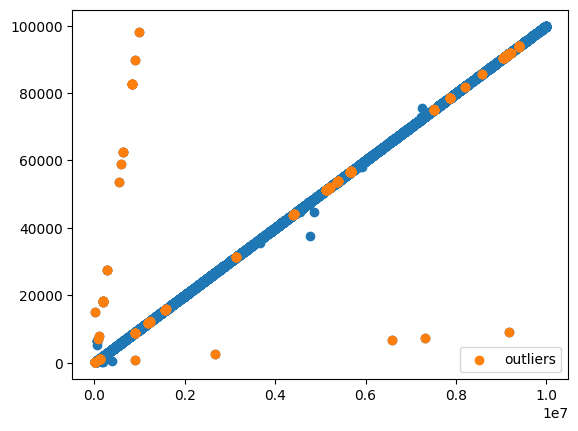

In [12]:
from sklearn.neighbors import LocalOutlierFactor


clf = LocalOutlierFactor(n_neighbors=60)
preds = clf.fit_predict(df_source[['price', 'squareMeters']])

outlier_indices = np.where(preds == -1)[0]
outlier_subset = df_source.iloc[outlier_indices]

_, ax = plt.subplots()
ax.scatter(df_source['price'], df_source['squareMeters'])
ax.scatter(outlier_subset['price'], outlier_subset['squareMeters'], label='outliers')
ax.legend()

We will clean (244,) outliers
shape before: (22684, 17)
shape after: (22440, 17)
(22440, 17)


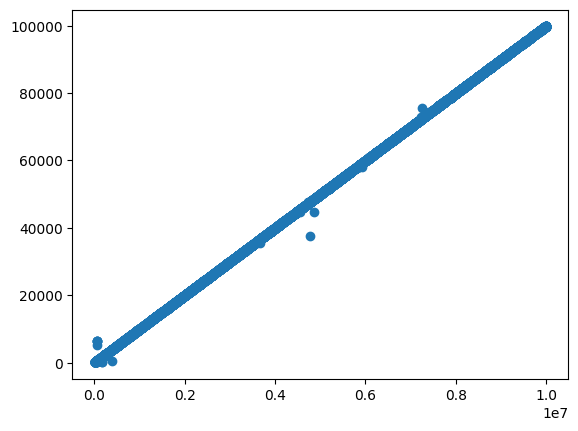

In [13]:
print(f'We will clean {outlier_indices.shape} outliers')

print(f'shape before: {df_source.shape}')
df_source = df_source.iloc[~df_source.index.isin(outlier_subset.index), :]
print(f'shape after: {df_source.shape}')

_, ax = plt.subplots()
ax.scatter(df_source['price'], df_source['squareMeters'])

print(df_source.shape)

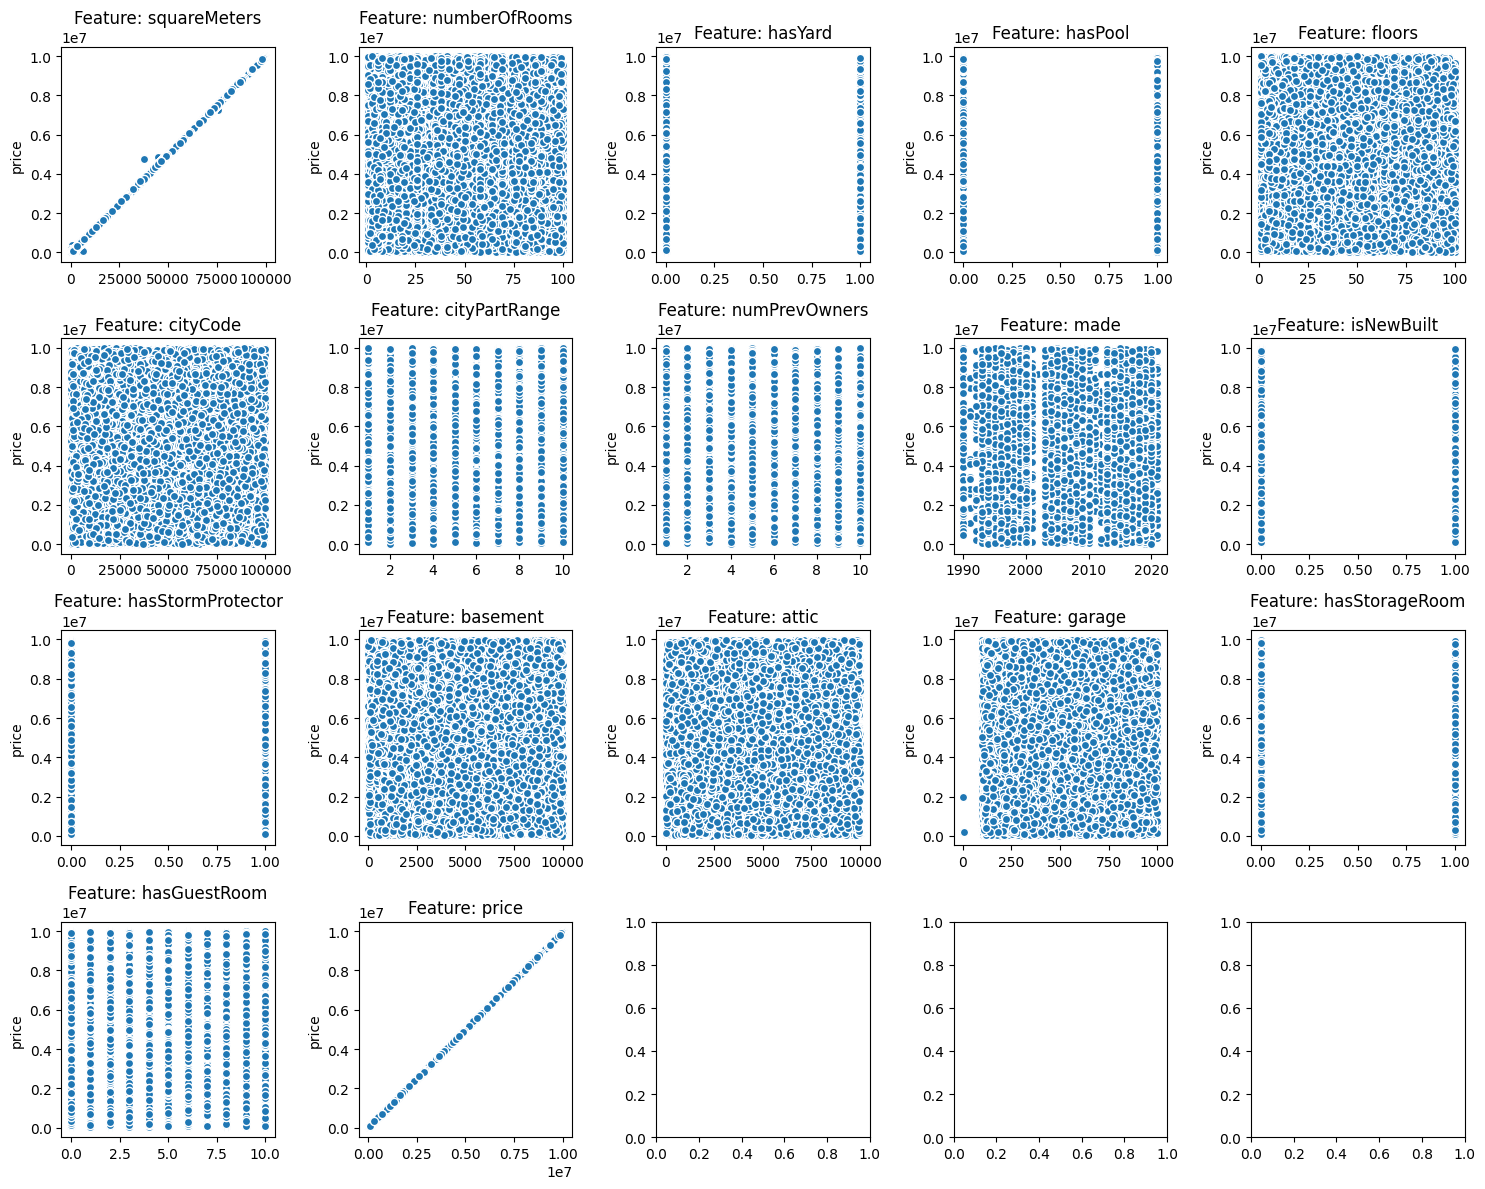

In [14]:
visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=5,
    height_scale=3.0
)

# Split the data

In [15]:
TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8
EXPLORATION_SIZE = 0.5
RANDOM_STATE = 42

In [16]:
from sklearn.model_selection import train_test_split

df_trainval, df_test = train_test_split(
    df_source,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE
)

df_trainval.shape, df_test.shape

((17952, 17), (4488, 17))

In [17]:
df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE
)

df_train.shape, df_val.shape

((14361, 17), (3591, 17))

In [18]:
df_exploration, _ = train_test_split(
    df_train,
    train_size=EXPLORATION_SIZE,
    random_state=RANDOM_STATE
)

df_exploration.shape

(7180, 17)

In [19]:
def X_Y(df, return_y=True):

    X = df.loc[:, df.columns != 'price']
    if return_y:
        Y = df['price']
        return X, Y
    else:
        return X, None

X_train, Y_train = X_Y(df_train)
X_val, Y_val = X_Y(df_val)

## Check target distribution

Visualizing datasets distributions
(1, 1) <class 'numpy.ndarray'>


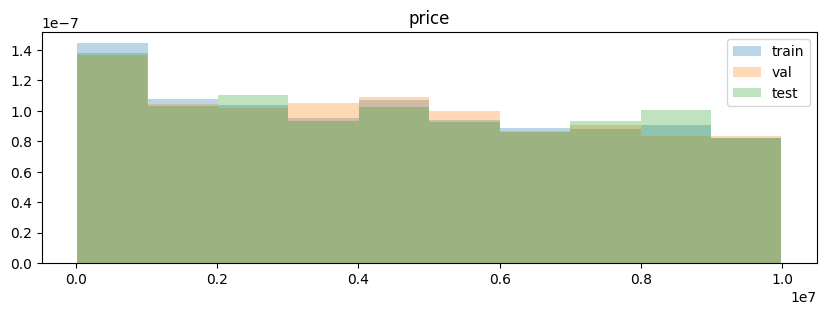

In [20]:
from sklearn_utils import visualize_datasets_distributions

visualize_datasets_distributions(
    {
        'train': df_train,
        'val': df_val,
        'test': df_test,
    },
    ['price'],
    grid_width=1
)

# Data exploration (from now on - on train df only)

## Overall

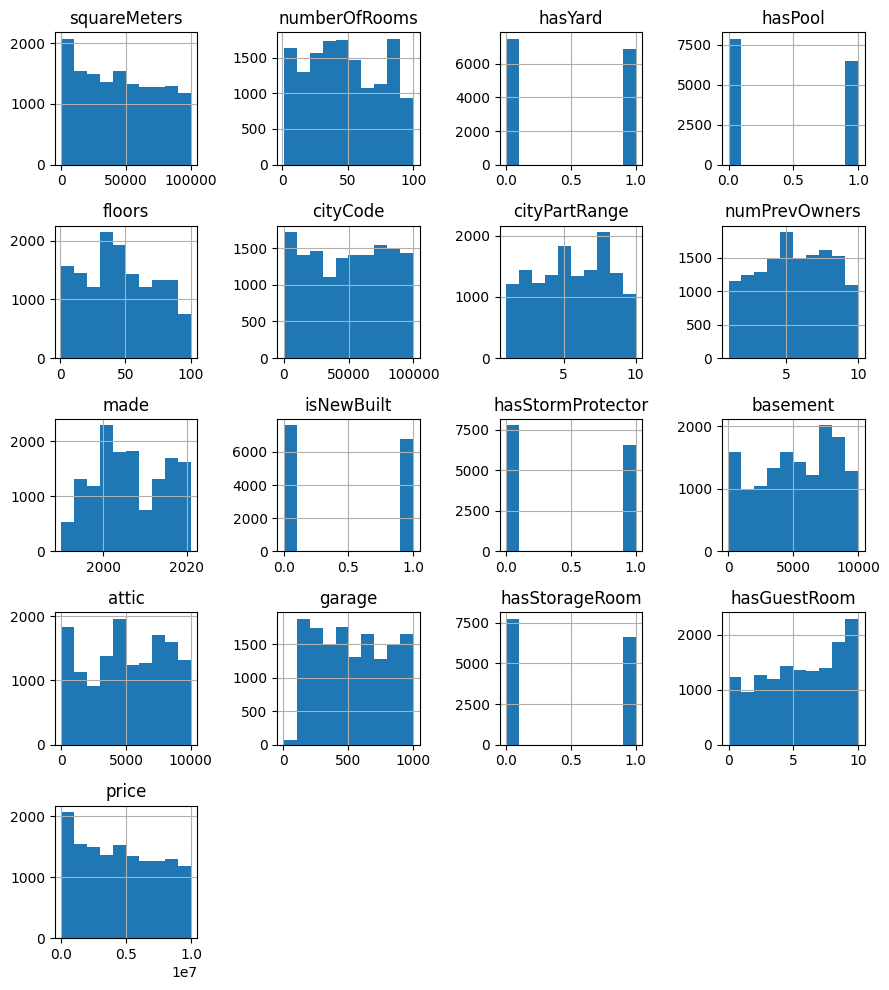

In [ ]:
_ = df_train.hist(figsize=(9, 10))
plt.tight_layout()

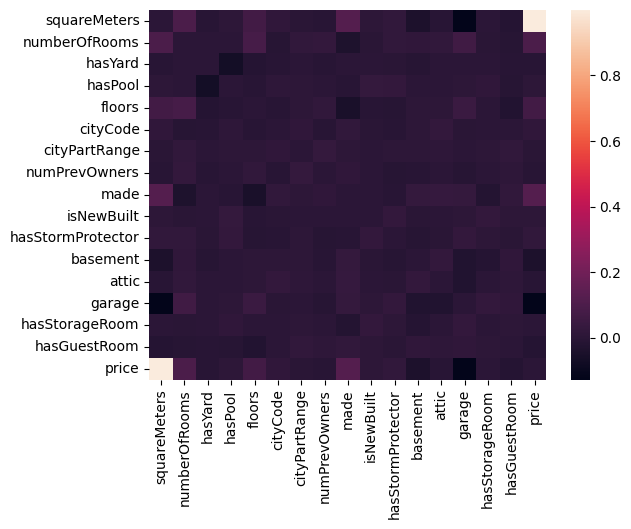

In [ ]:
from sklearn_utils import plot_correlation_matrix


_ = plot_correlation_matrix(df_train, delete_diagonals=True)

In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')

## squareMeters

<Axes: >

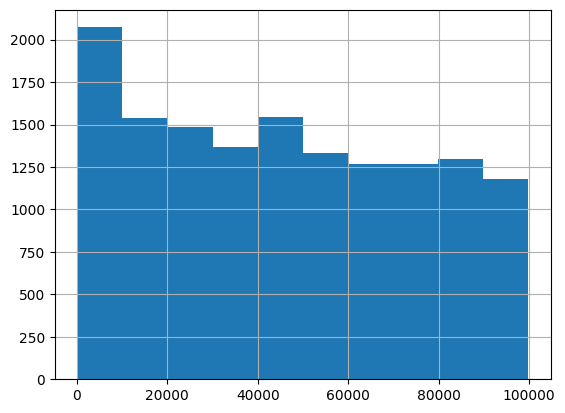

In [ ]:
df_train['squareMeters'].hist()

In [ ]:
df_train['squareMeters'].describe()

count    14361.000000
mean     46053.414734
std      29209.389570
min        137.000000
25%      19857.000000
50%      44111.000000
75%      71061.000000
max      99820.000000
Name: squareMeters, dtype: float64

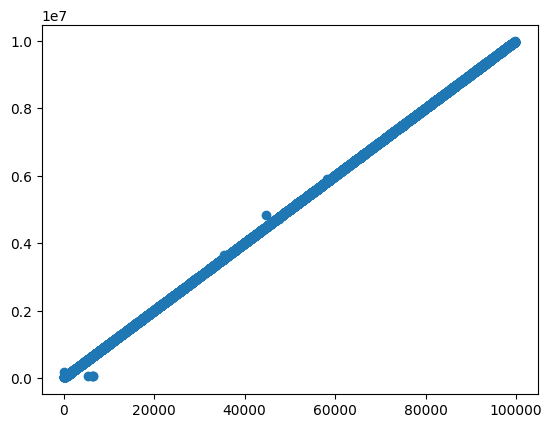

In [ ]:
plt.scatter(
    df_train['squareMeters'],
    df_train['price'],
)

(9, 17)


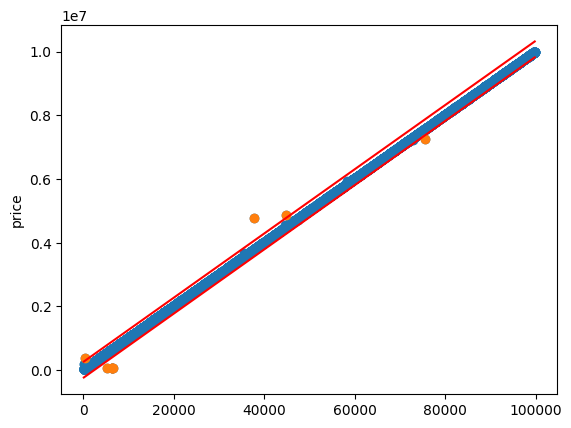

In [ ]:
_, ax = plt.subplots()
ax.scatter(
    y=df_source['price'],
    x=df_source['squareMeters']
)
ax.set_ylabel('price')

COEF = 100.83
x = np.linspace(df_source['squareMeters'].min(), df_source['squareMeters'].max(), 100)
y = np.array([COEF * x_ for x_ in x])
OFFSET = 250000
ax.plot(x, y + OFFSET, color='red')
ax.plot(x, y - OFFSET, color='red')

outlier_subset = df_source.loc[
    (df_source['price'] > df_source['squareMeters'] * COEF + OFFSET) |
    (df_source['price'] < df_source['squareMeters'] * COEF - OFFSET)
]
print(outlier_subset.shape)
ax.scatter(outlier_subset['squareMeters'], outlier_subset['price'])

In [ ]:
outlier_subset.head(10)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
986,6348,74,1,0,54,55403,4,7,2000,0,1,4245,7997,797,0,3,65465.1
6971,6397,80,1,0,84,46757,8,6,2020,0,0,7174,7486,746,0,5,65465.1
9316,75486,78,1,1,84,42527,9,10,2000,1,0,7325,3753,308,0,10,7254308.1
9663,380,86,1,1,81,96283,10,7,2000,1,0,5131,7793,411,0,8,383898.1
12685,5277,87,0,0,26,76242,5,9,2000,1,1,8687,786,218,0,9,53940.1
13156,37647,50,0,0,38,5644,5,4,2015,1,1,985,989,574,0,3,4773675.5
13365,6396,86,1,0,31,31987,6,5,2000,0,0,5645,3491,602,1,10,65465.1
14589,44731,87,0,0,77,63006,5,6,2013,0,0,5379,889,313,1,6,4852762.3
15653,6453,41,0,1,52,57460,4,7,2020,0,1,759,6838,186,0,4,65465.1


## NumberOfRooms

<Axes: >

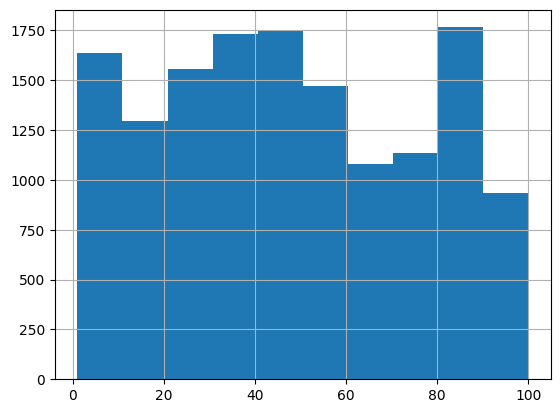

In [ ]:
df_train['numberOfRooms'].hist()

<Axes: xlabel='numberOfRooms', ylabel='price'>

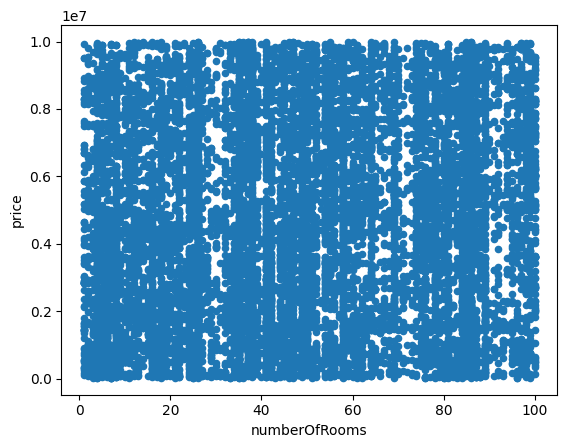

In [ ]:
df_train.plot.scatter('numberOfRooms', 'price')

In [ ]:
df_train[['price', 'numberOfRooms']].corr()

,price,numberOfRooms
price,1.000000,0.095754
numberOfRooms,0.095754,1.000000


## hasYard

0         Axes(0.1,0.15;0.363636x0.75)
1    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

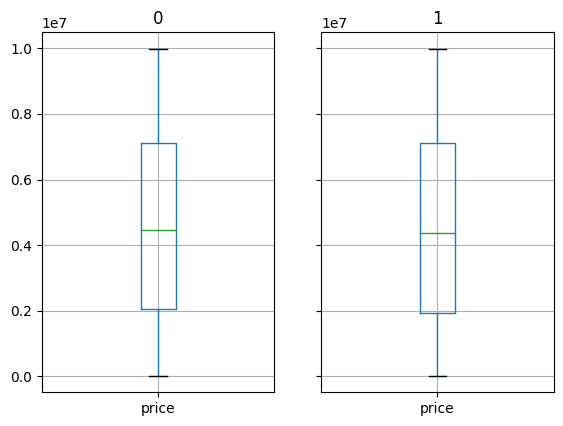

In [ ]:
df_train.groupby('hasYard')[['price']].boxplot()

<Axes: xlabel='hasYard'>

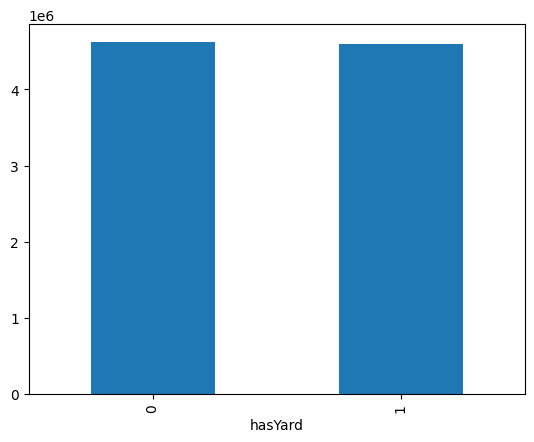

In [ ]:
df_train.groupby('hasYard')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

## hasPool

0         Axes(0.1,0.15;0.363636x0.75)
1    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

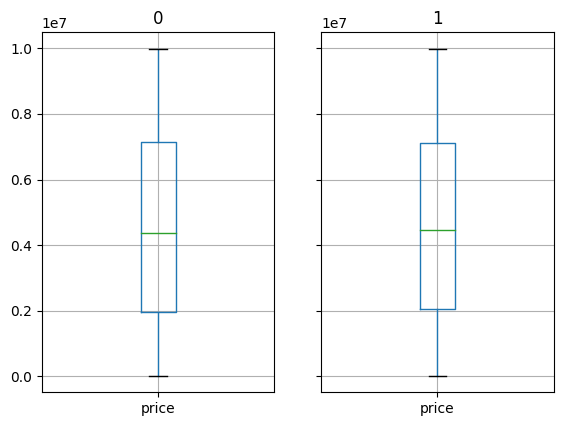

In [ ]:
df_train.groupby('hasPool')[['price']].boxplot()

<Axes: xlabel='hasPool'>

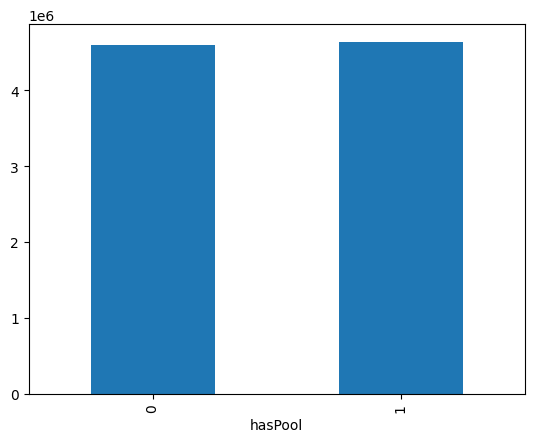

In [ ]:
df_train.groupby('hasPool')['price'].aggregate('mean').plot(kind='bar')

## floors

<Axes: >

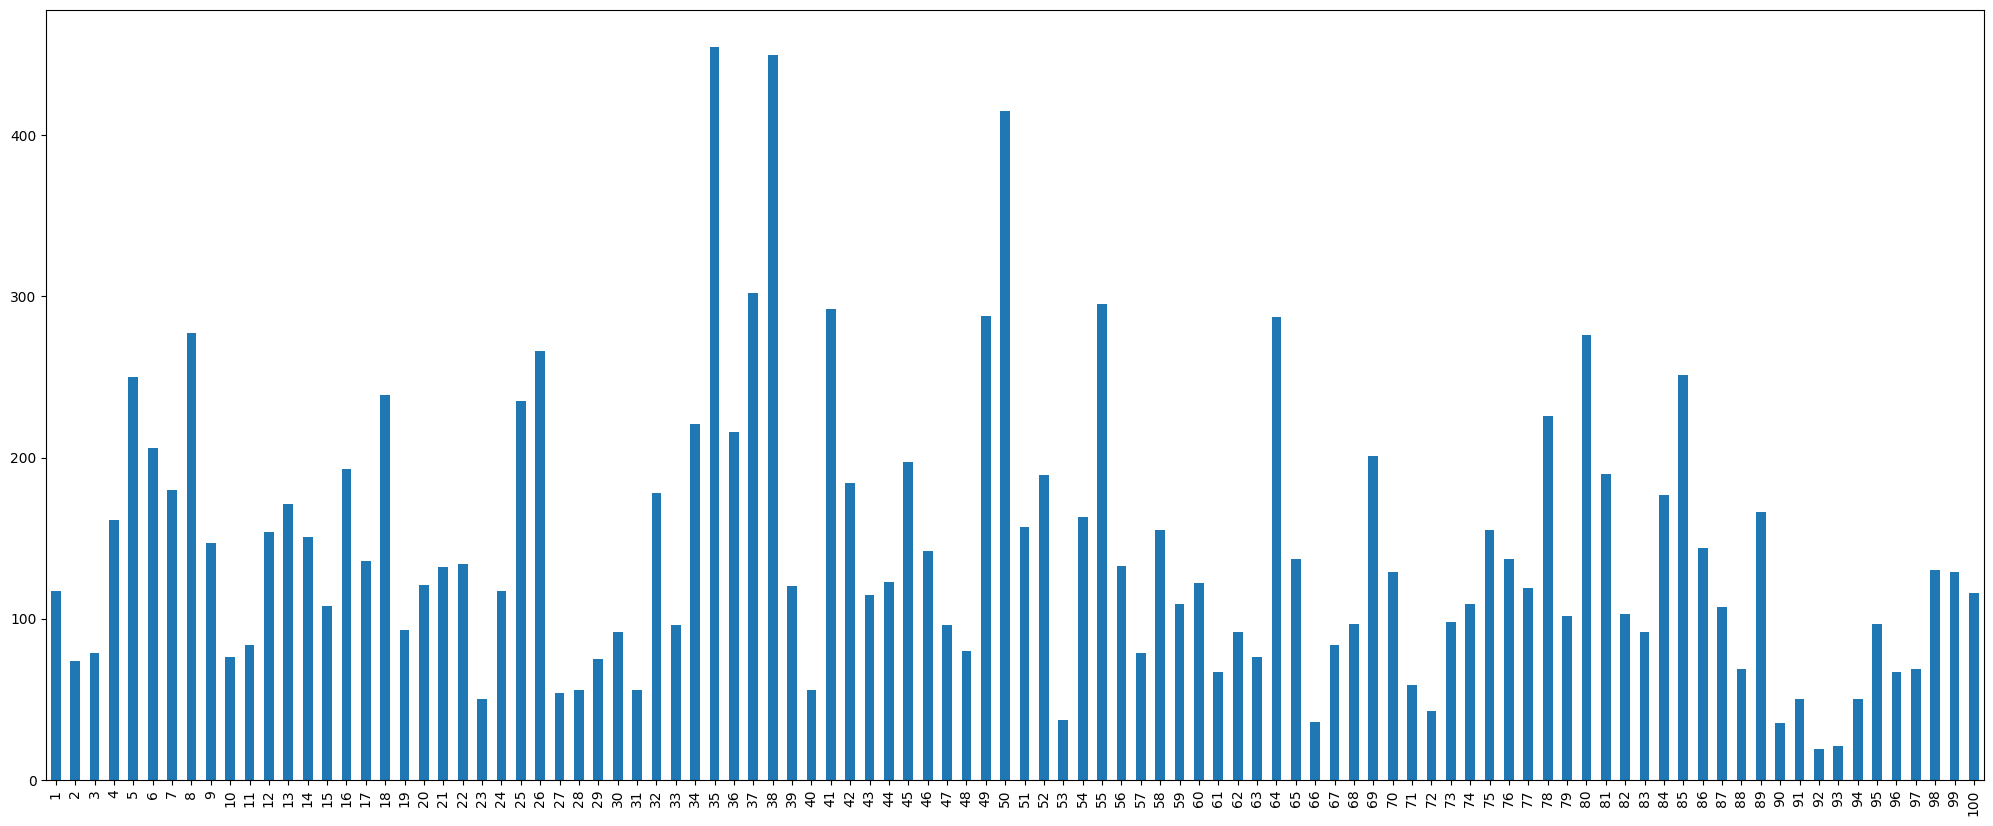

In [ ]:
df_train.floors \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar', figsize=(25, 10))

<Axes: xlabel='floors'>

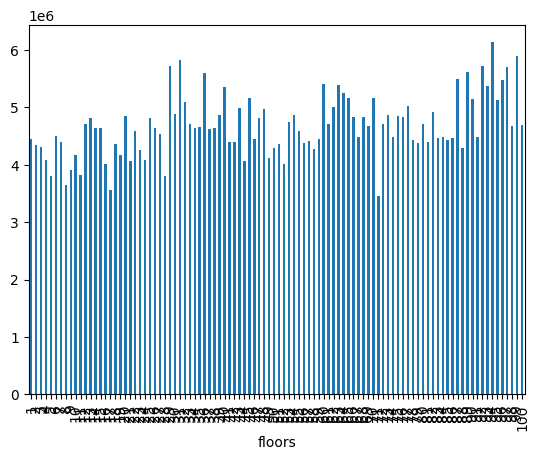

In [ ]:
df_train \
    .groupby('floors')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

<Axes: xlabel='floors', ylabel='price'>

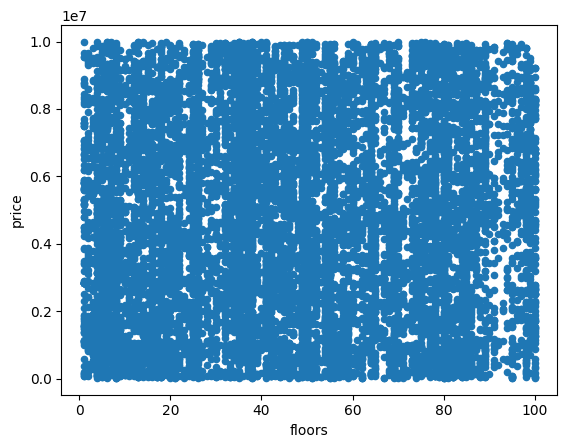

In [ ]:
df_train.plot.scatter(x='floors', y='price')

<Axes: xlabel='floors_binned'>

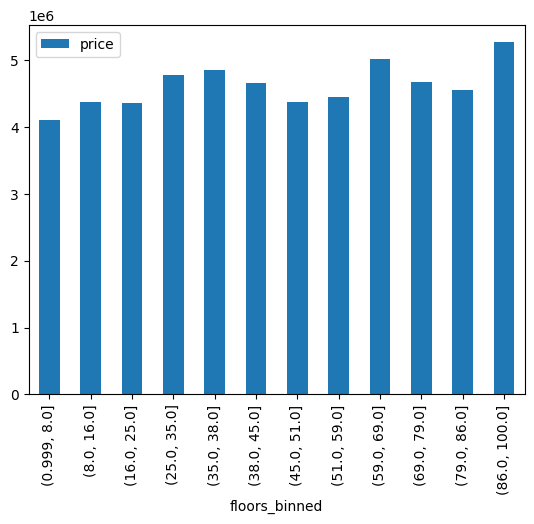

In [ ]:
df_train['floors_binned'] = pd.qcut(
    df_train['floors'],
    q=np.linspace(0.0, 1.0, num=13, endpoint=True)
)

df_train \
    .groupby('floors_binned')[['price']] \
    .aggregate('mean') \
    .plot(kind='bar')

In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'boxesChecked', 'floors_binned'],
      dtype='object')

## cityCode

<Axes: >

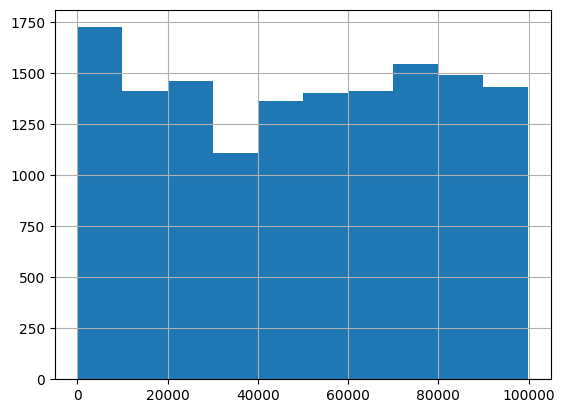

In [22]:
df_train.cityCode.hist()

<Axes: xlabel='cityCodeBinned'>

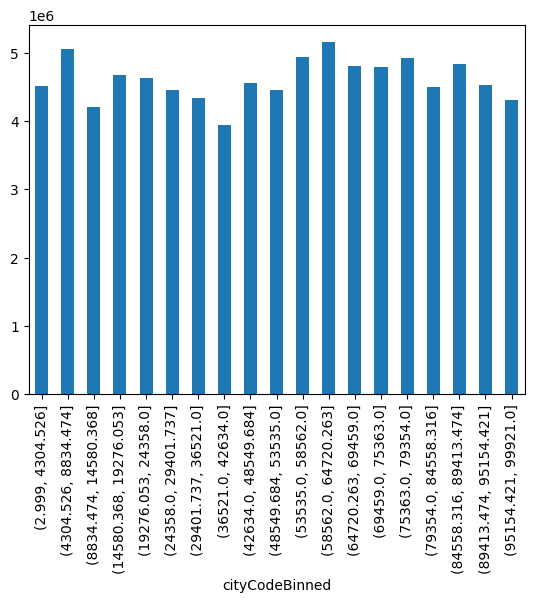

In [25]:
df_train['cityCodeBinned'] = pd.qcut(df_train['cityCode'], np.linspace(0.0, 1.0, num=20))
df_train \
    .groupby('cityCodeBinned')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

In [26]:
df_train.cityCodeBinned.value_counts().sum(), df_train.shape[0]

(14361, 14361)

## cityPartRange

<Axes: >

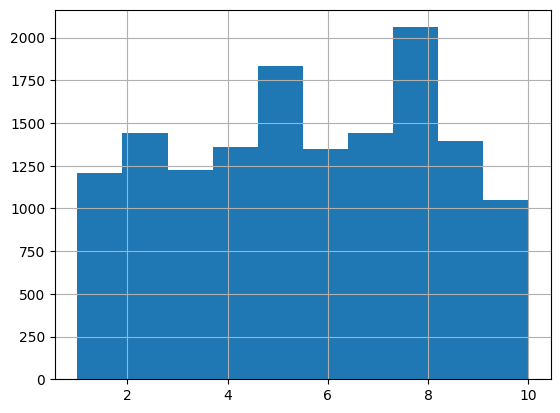

In [28]:
df_train['cityPartRange'].hist()

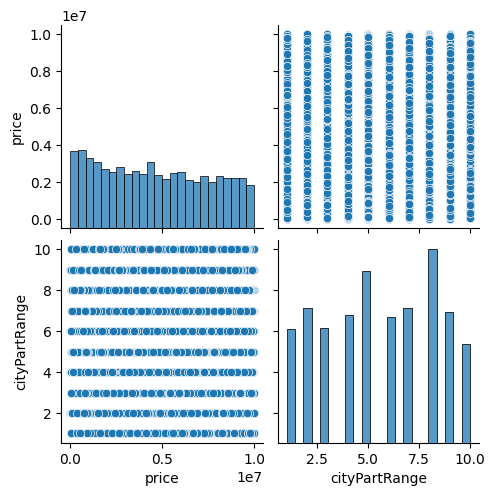

In [29]:
sns.pairplot(df_train[['price', 'cityPartRange']])

In [36]:
df_train.cityPartRange.unique()

array([ 4,  3,  7,  1,  5, 10,  6,  8,  9,  2])

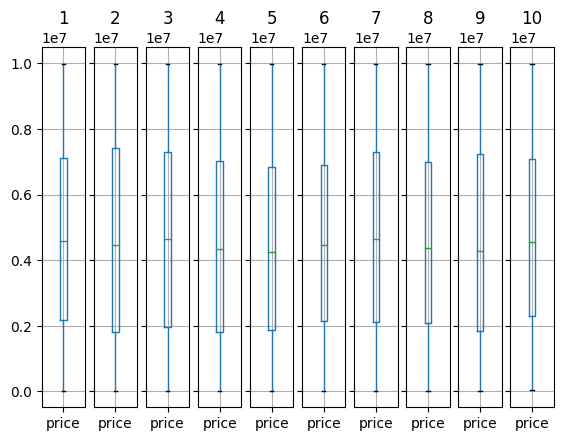

In [46]:
_ = df_train \
    .groupby('cityPartRange')[['price']] \
    .boxplot(sharex=False, layout=(1, 10))

<Axes: xlabel='cityPartRangeBinned,cityCodeBinned'>

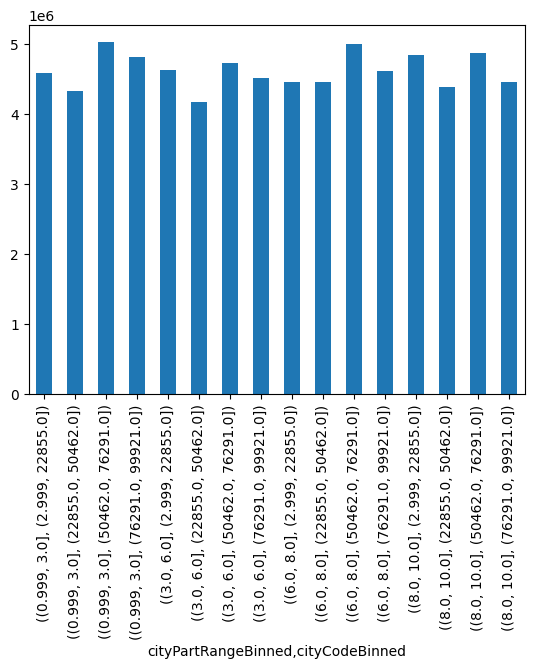

In [47]:
df_train['cityPartRangeBinned'] = pd.qcut(
    df_train['cityPartRange'],
    np.linspace(0.0, 1.0, num=5, endpoint=True)
)

df_train.groupby(['cityPartRangeBinned', 'cityCodeBinned'])['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

<Axes: >

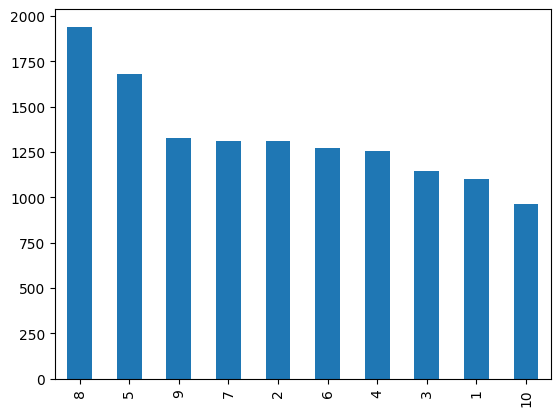

In [ ]:
df_train.cityPartRange.value_counts().plot(kind='bar')

<Axes: xlabel='cityPartRange'>

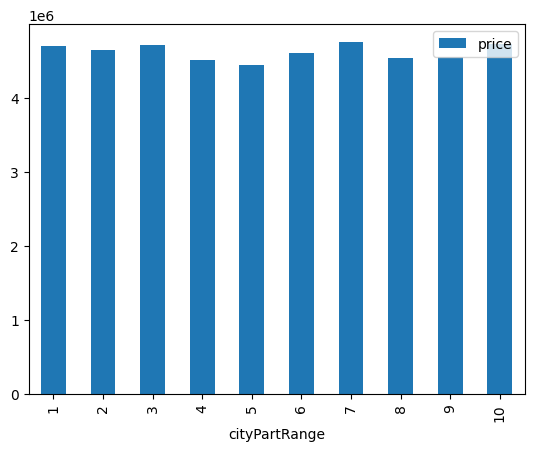

In [49]:
df_train.groupby('cityPartRange')[['price']] \
    .aggregate('mean') \
    .plot(kind='bar')

In [50]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned'],
      dtype='object')

## numPrevOwners

<Axes: >

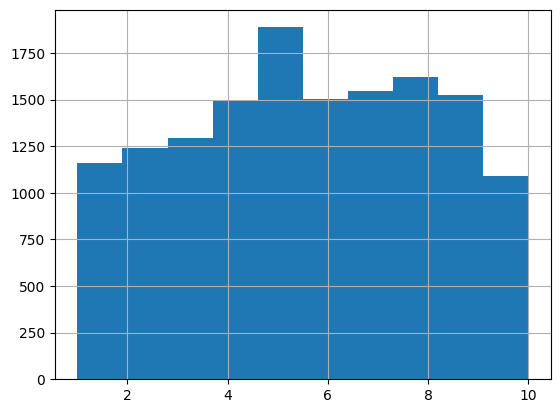

In [51]:
df_train.numPrevOwners.hist()

<Axes: >

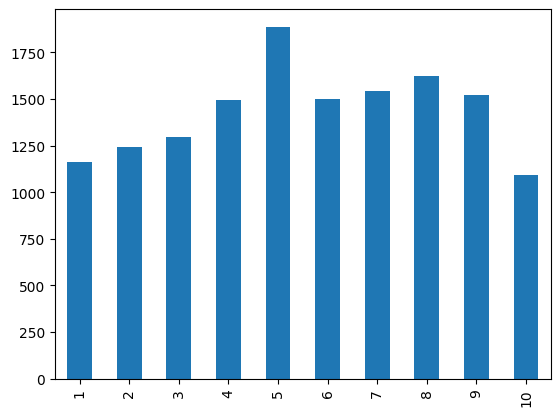

In [53]:
df_train.numPrevOwners \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar')

<Axes: xlabel='numPrevOwners'>

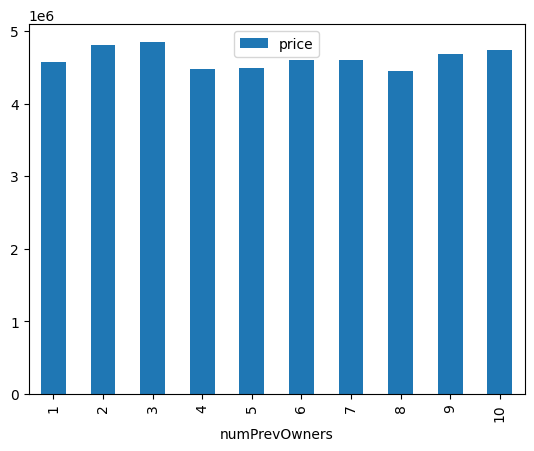

In [61]:
df_train \
    .groupby('numPrevOwners')[['price']] \
    .aggregate('mean') \
    .plot(kind='bar')

In [62]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned'],
      dtype='object')

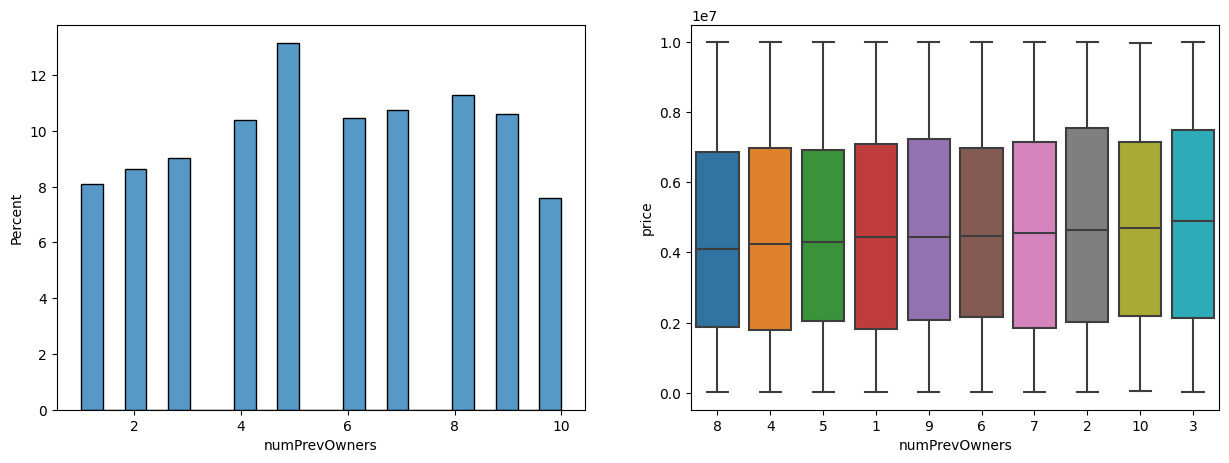

In [101]:
from sklearn_utils import boxplot_regression

boxplot_regression(df_train, 'numPrevOwners', 'price')

## made

<Axes: >

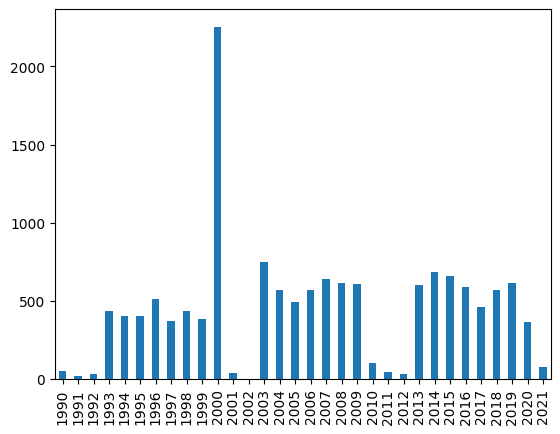

In [68]:
df_train['made'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='made'>

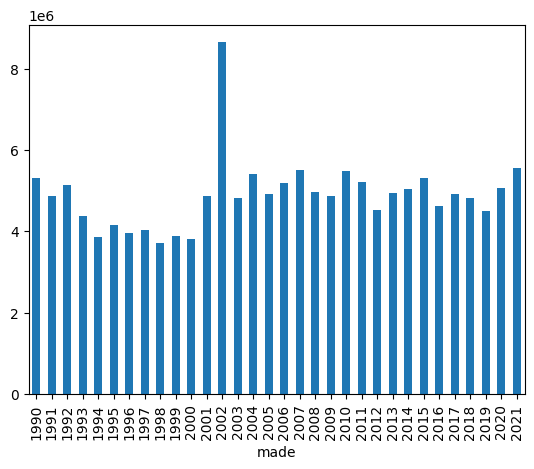

In [69]:
df_train.groupby('made')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

In [70]:
df_train[df_train['made'] == 2002]

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cityCodeBinned,cityPartRangeBinned
id,,,,,,,,,,,,,,,,,,,
8337,86383,95,0,0,8,98660,3,10,2002,1,1,4118,4349,877,1,7,8648031.0,"(76291.0, 99921.0]","(0.999, 3.0]"


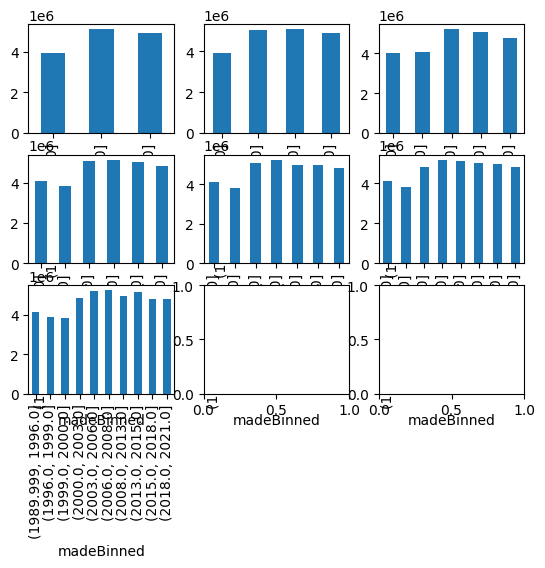

In [90]:
_, ax = plt.subplots(3, 3)
ax = ax.flatten()
i = 0
for n_bins in [4, 5, 6, 7, 8, 9, 11]:
    df_train['madeBinned'] = pd.qcut(
        df_train['made'],
        np.linspace(0.0, 1.0, n_bins, endpoint=True)
    )

    df_train \
        .groupby('madeBinned')['price'] \
        .aggregate('mean') \
        .plot(kind='bar', ax=ax[i])
    i += 1

In [91]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned',
       'madeBinned'],
      dtype='object')

## isNewBuilt

<Axes: >

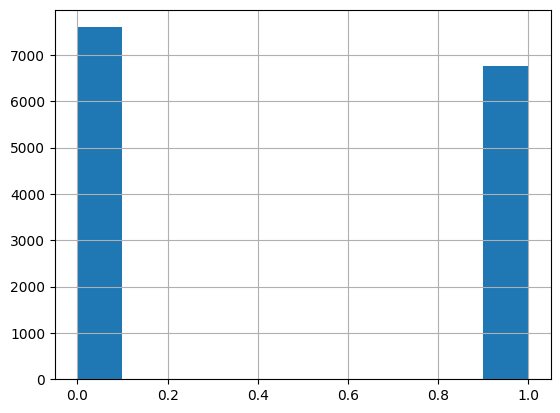

In [92]:
df_train['isNewBuilt'].hist()

<Axes: xlabel='isNewBuilt'>

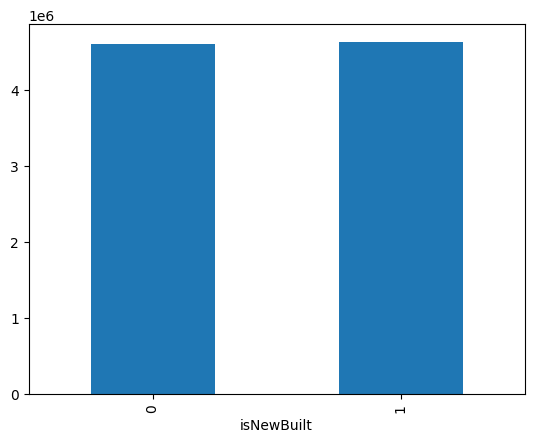

In [93]:
df_train \
    .groupby('isNewBuilt')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

0         Axes(0.1,0.15;0.363636x0.75)
1    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

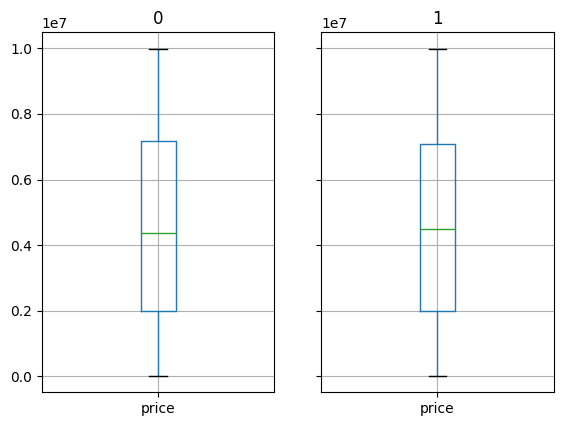

In [94]:
df_train.groupby('isNewBuilt')[['price']].boxplot()

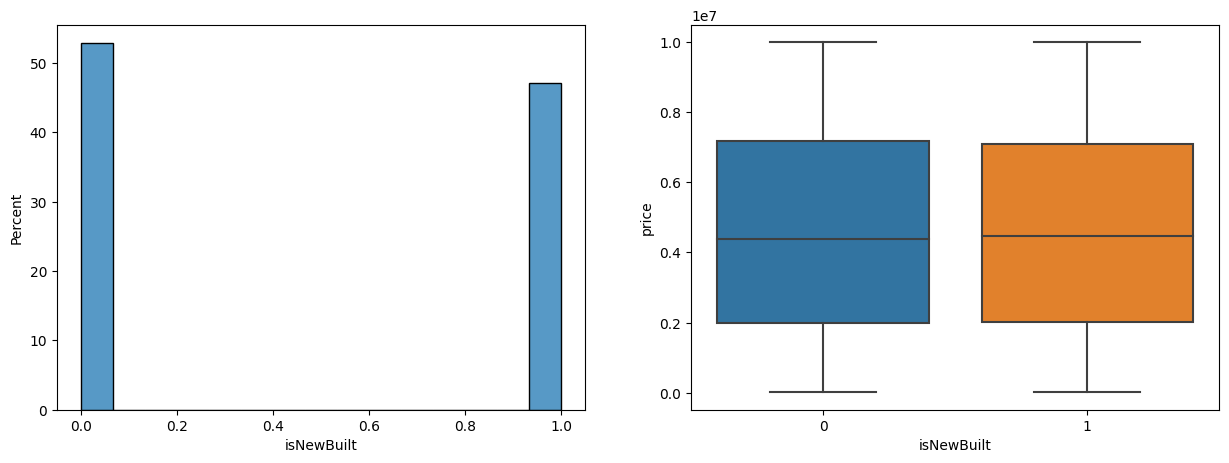

In [99]:
from sklearn_utils import boxplot_regression

boxplot_regression(df_train, 'isNewBuilt', 'price')

In [102]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned',
       'madeBinned'],
      dtype='object')

## hasStormProtector

<Axes: >

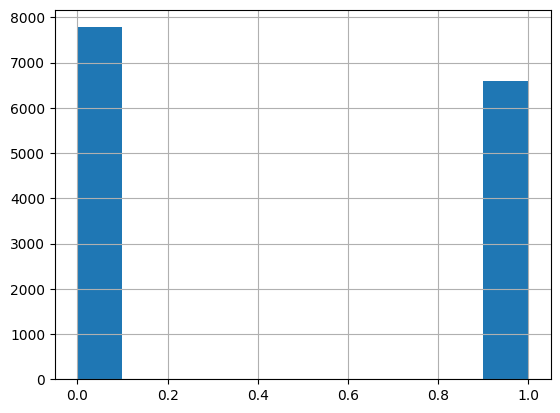

In [103]:
df_train.hasStormProtector.hist()

<Axes: xlabel='hasStormProtector'>

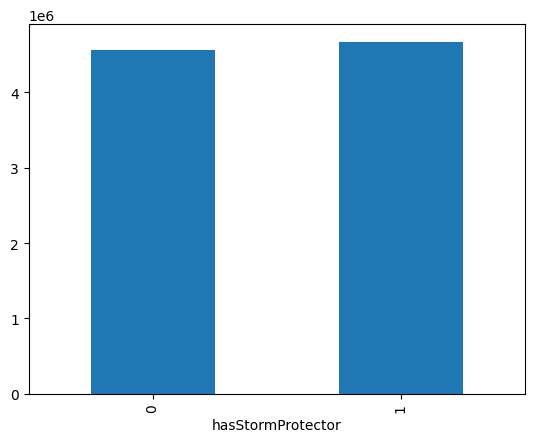

In [104]:
df_train.groupby('hasStormProtector')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

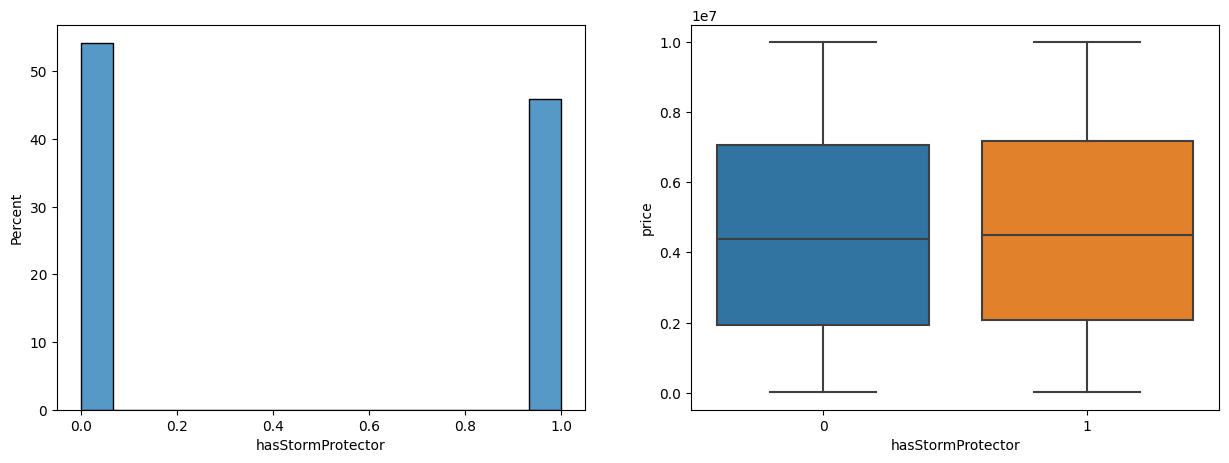

In [105]:
from sklearn_utils import boxplot_regression

boxplot_regression(
    df_train,
    'hasStormProtector',
    'price'
)

In [106]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned',
       'madeBinned'],
      dtype='object')

## basement

<Axes: >

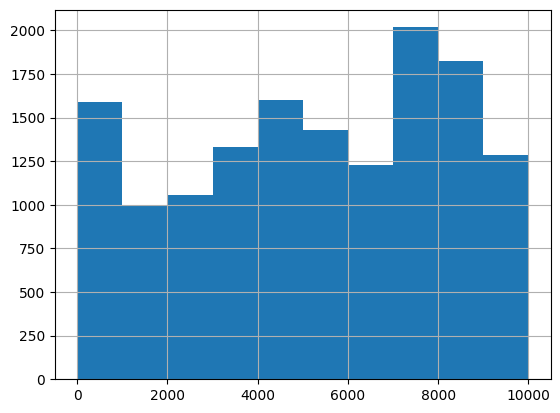

In [107]:
df_train['basement'].hist()

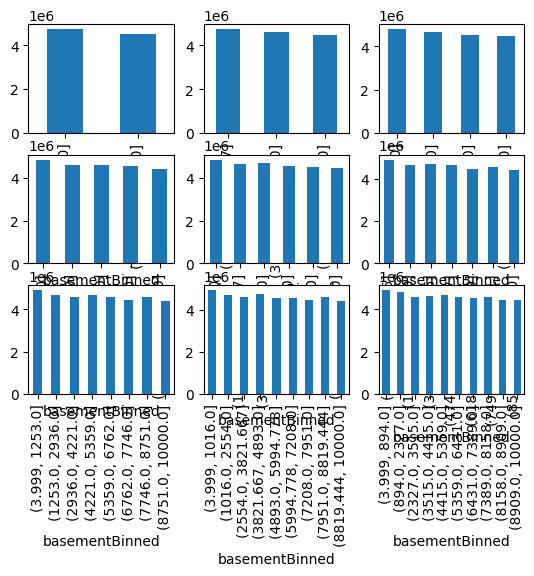

In [111]:
n_bins = np.arange(3, 12)
_, ax = plt.subplots(3, 3)
ax = ax.flatten()

for i, n in enumerate(n_bins):

    df_train['basementBinned'] = pd.qcut(
        df_train['basement'],
        np.linspace(0.0, 1.0, n)
    )

    df_train \
        .groupby('basementBinned')['price'] \
        .aggregate('mean') \
        .plot(kind='bar', ax=ax[i])

## Attic

<Axes: >

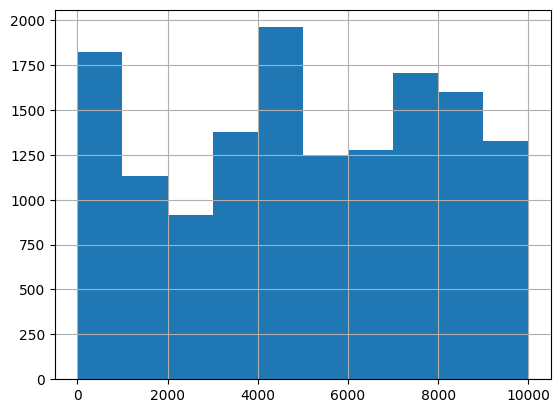

In [113]:
df_train.attic.hist()

<ipython-input-119-60671cd91597>:16: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


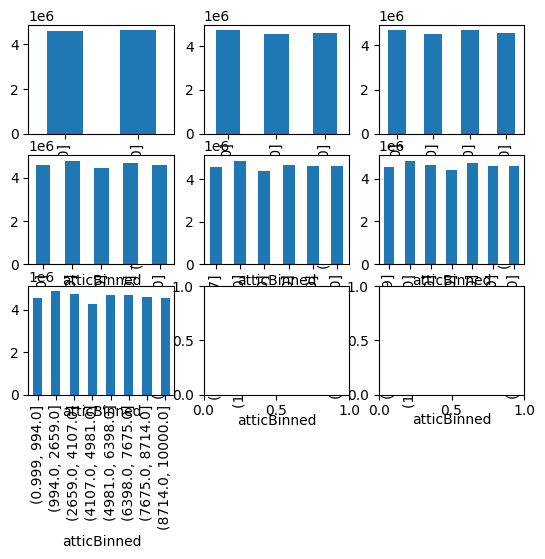

In [119]:
n_bins = np.arange(3, 10)
_, ax = plt.subplots(3, 3)
ax = ax.flatten()

for i, n in enumerate(n_bins):

    df_train['atticBinned'] = pd.qcut(
        df_train['attic'],
        np.linspace(0, 1, n, endpoint=True)
    )

    df_train.groupby('atticBinned')['price'] \
        .aggregate('mean') \
        .plot(kind='bar', ax=ax[i])

plt.tight_layout()

## garage

<Axes: >

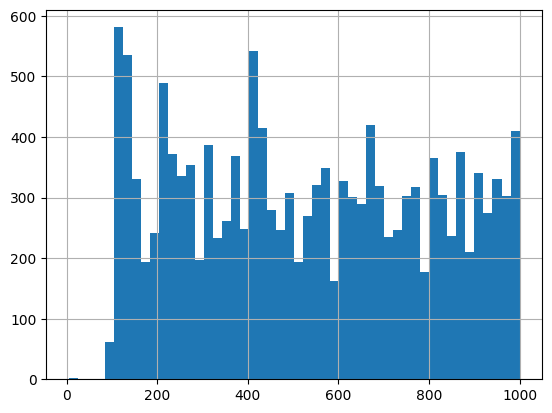

In [122]:
df_train.garage.hist(bins=50)

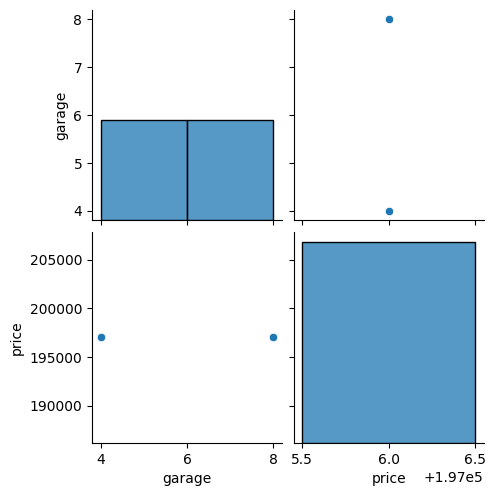

In [126]:
sns.pairplot(df_train[df_train.garage < 50][['garage', 'price']])

In [127]:
df_train[df_train['garage'] < 50].head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cityCodeBinned,cityPartRangeBinned,madeBinned,basementBinned,atticBinned
id,,,,,,,,,,,,,,,,,,,,,,
3130,1863,82,1,1,81,40618,1,4,2000,0,0,7113,8,4,1,1,197006.0,"(22855.0, 50462.0]","(0.999, 3.0]","(1999.0, 2000.0]","(6431.0, 7389.0]","(0.999, 994.0]"
11910,1863,41,1,1,80,40631,4,4,2000,0,0,6283,8,8,1,4,197006.0,"(22855.0, 50462.0]","(3.0, 6.0]","(1999.0, 2000.0]","(5359.0, 6431.0]","(0.999, 994.0]"


In [133]:
df_train[~df_train['garage'] < 70].shape

(14361, 22)

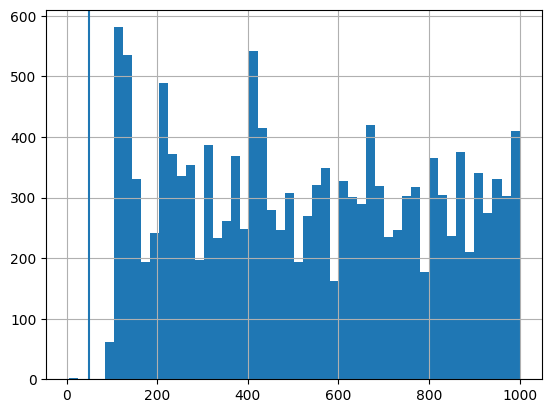

In [144]:
ax = df_train.garage.hist(bins=50)
ax.axvline(50)

In [148]:
df_train['price'].duplicated().sum(), df_train.shape

(8121, (14361, 22))

In [145]:
df_train[df_train['garage'] < 50].head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cityCodeBinned,cityPartRangeBinned,madeBinned,basementBinned,atticBinned
id,,,,,,,,,,,,,,,,,,,,,,
3130,1863,82,1,1,81,40618,1,4,2000,0,0,7113,8,4,1,1,197006.0,"(22855.0, 50462.0]","(0.999, 3.0]","(1999.0, 2000.0]","(6431.0, 7389.0]","(0.999, 994.0]"
11910,1863,41,1,1,80,40631,4,4,2000,0,0,6283,8,8,1,4,197006.0,"(22855.0, 50462.0]","(3.0, 6.0]","(1999.0, 2000.0]","(5359.0, 6431.0]","(0.999, 994.0]"


<Axes: >

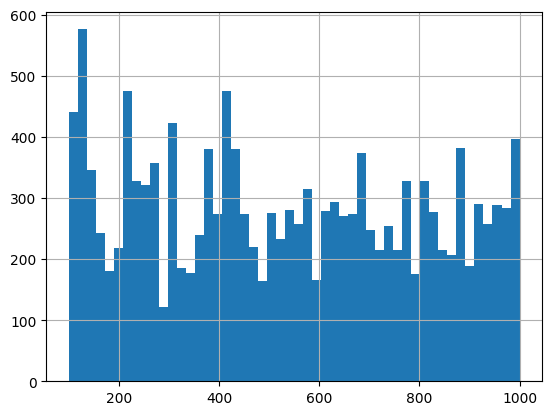

In [141]:
df_train[df_train['garage'] >= 50]['garage'].hist(bins=50)

## hasStorageRoom

<Axes: >

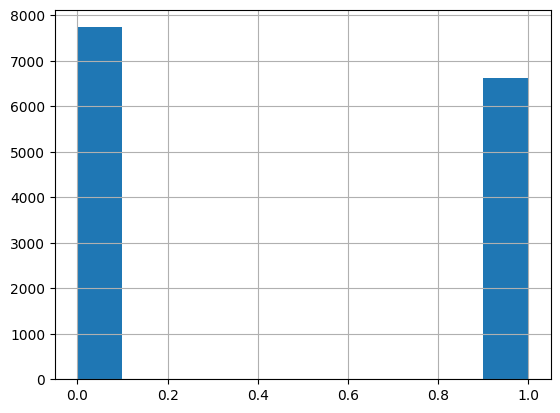

In [160]:
df_train.hasStorageRoom.hist()

<Axes: xlabel='hasStorageRoom'>

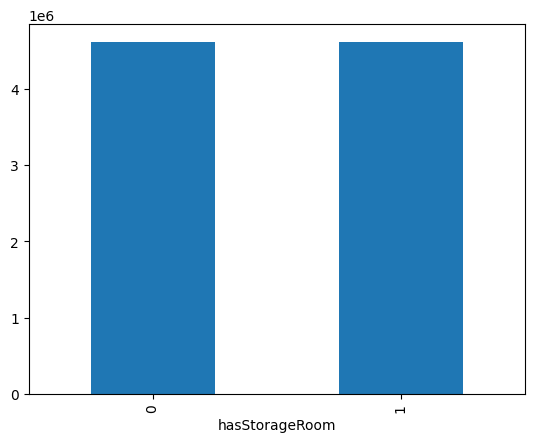

In [161]:
df_train \
    .groupby('hasStorageRoom')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

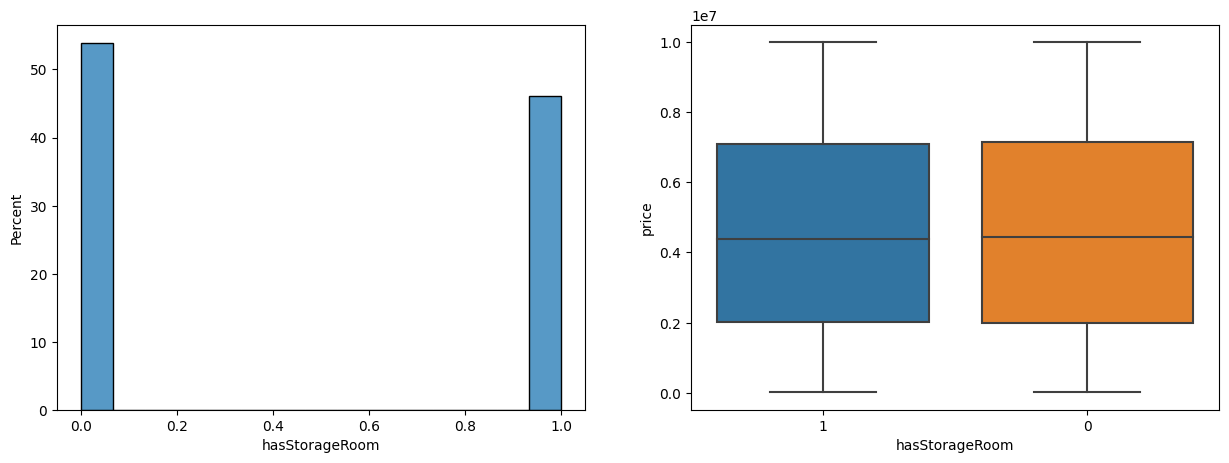

In [162]:
from sklearn_utils import boxplot_regression

boxplot_regression(df_train, 'hasStorageRoom', 'price')

## hasGuestRoom

<Axes: >

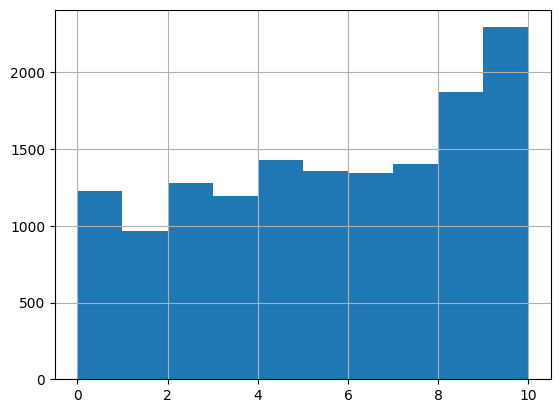

In [164]:
df_train.hasGuestRoom.hist()

In [166]:
df_train.hasGuestRoom.unique()

array([10,  5,  8,  9,  1,  3,  2,  4,  6,  0,  7])

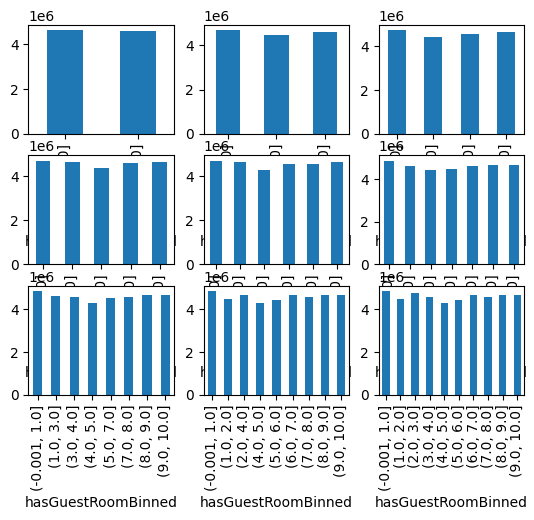

In [167]:
n_bins = np.arange(3, 12)
_, ax = plt.subplots(3, 3)
ax = ax.flatten()

for i, n in enumerate(n_bins):

    df_train['hasGuestRoomBinned'] = pd.qcut(
        df_train['hasGuestRoom'],
        np.linspace(0, 1, n, endpoint=True)
    )

    df_train.groupby('hasGuestRoomBinned')['price'] \
        .aggregate('mean') \
        .plot(kind='bar', ax=ax[i])

## price

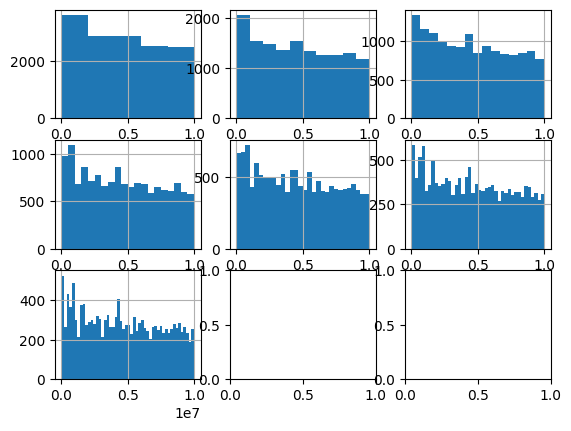

In [172]:
_, ax = plt.subplots(3, 3)
ax = ax.flatten()

for i, b in enumerate([5, 10, 15, 20, 30, 40, 50]):
    df_train.price.hist(bins=b, ax=ax[i])

<Axes: >

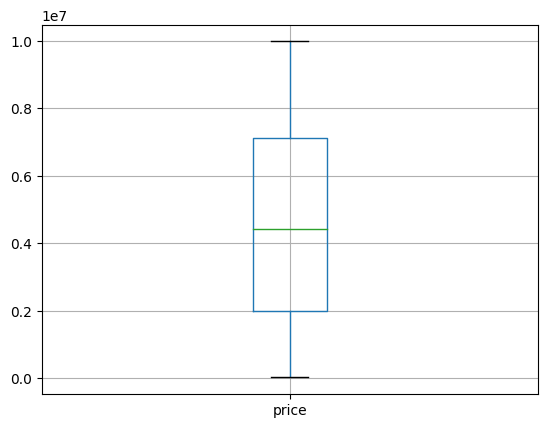

In [174]:
df_train[['price']].boxplot()

# Feature engineering possibilities

## boxesChecked

<Axes: xlabel='hasYard,hasPool,hasStormProtector,hasStorageRoom,isNewBuilt'>

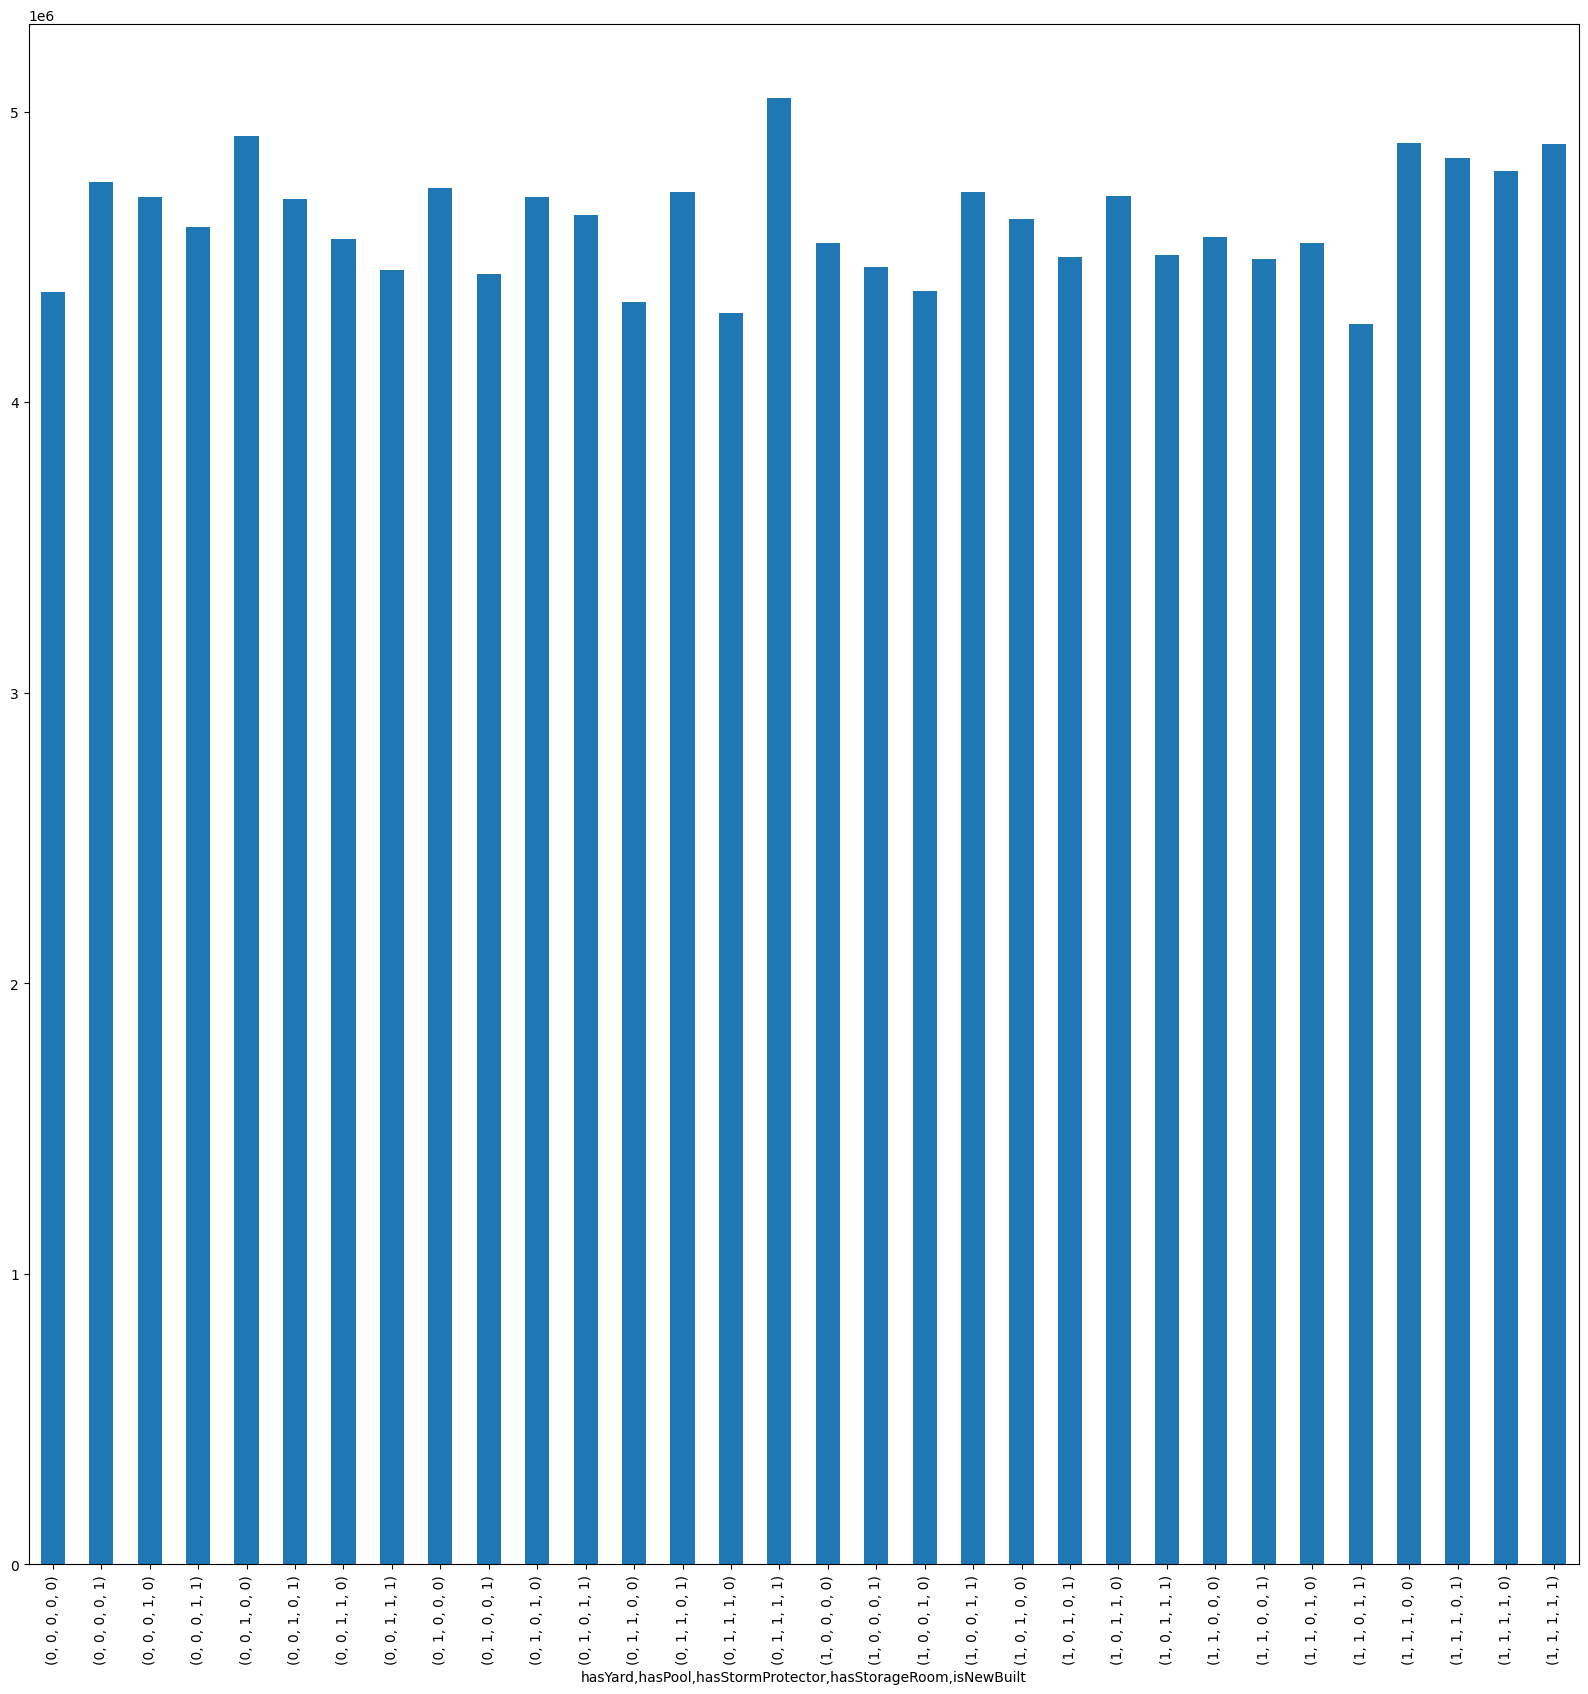

In [ ]:
df_train \
    .groupby(
        [
            'hasYard',
            'hasPool',
            'hasStormProtector',
            'hasStorageRoom',
            'isNewBuilt'
            # 'hasGuestRoom'
        ]
    )['price'] \
    .aggregate('mean') \
    .plot(kind='bar', figsize=(20, 20))

In [ ]:
df_train['boxesChecked'] = \
    df_train['hasYard'] + \
    df_train['hasPool'] + \
    df_train['hasStormProtector'] + \
    df_train['hasStorageRoom'] + \
    df_train['isNewBuilt'] + \
    (df_train['hasGuestRoom'] > 0)


<Axes: xlabel='boxesChecked'>

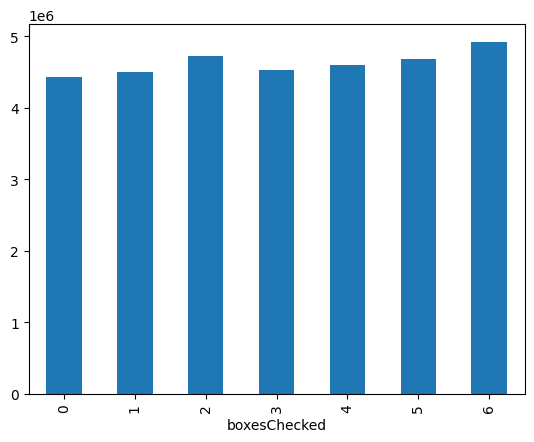

In [ ]:
df_train.groupby('boxesChecked')['price'].aggregate('mean').plot(kind='bar')

In [ ]:
df_train.hasGuestRoom.unique()

array([10,  5,  8,  9,  1,  3,  2,  4,  6,  0,  7])

# Conclusions

- Clean outliers (anomalies) before splitting the datasets
- squareMeters is in perfect correlation with target
- add boxesChecked feature
- add the binned floors feature
- add the cityCodeBinned feature
- add the madeBinned feature